In [1]:
import skimage
import skimage.io
import matplotlib.pyplot as plt

import glob
data = [skimage.io.imread(filename) for filename in glob.glob('*.tif')]

In [2]:
print(glob.glob('*'))

['1045_Steel_Nital-etch-06.tif', 'README.md~', '20150911_1045_Nital_etch.tif', '1045_Steel_Nital-etch-04.tif', '1045_Steel_Nital-etch-03.tif', 'README.md', 'LICENSE', '1045_Steel_Nital-etch-01.tif', 'lfs', 'test.txt', '20150911_1045_Nital_etch2.tif', 'test.png.1', '1045_Steel_Nital-etch-07.tif', 'test.png', '1045_Steel_Nital-etch-02.tif', 'test-european.jpg', '1045_Steel_Nital-etch-05.tif', 'index.ipynb', 'download_mdcs_images.py']


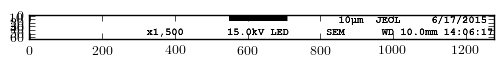

In [3]:
%matplotlib inline
plt.imshow(data[0][960:])

In [4]:
skimage.io.imsave('test.png', data[0][960:])

/home/wd15/anaconda/envs/shengyen/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from uint16 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [17]:
print(data[0][500:600, 501])

[[32896 32896 32896]
 [30069 30069 30069]
 [27242 27242 27242]
 [23130 23130 23130]
 [22616 22616 22616]
 [23644 23644 23644]
 [24158 24158 24158]
 [27242 27242 27242]
 [30326 30326 30326]
 [33153 33153 33153]
 [35723 35723 35723]
 [34952 34952 34952]
 [42148 42148 42148]
 [28527 28527 28527]
 [19275 19275 19275]
 [27242 27242 27242]
 [25700 25700 25700]
 [24158 24158 24158]
 [23644 23644 23644]
 [20560 20560 20560]
 [19275 19275 19275]
 [20560 20560 20560]
 [21845 21845 21845]
 [25443 25443 25443]
 [26985 26985 26985]
 [26214 26214 26214]
 [24929 24929 24929]
 [22102 22102 22102]
 [19789 19789 19789]
 [18247 18247 18247]
 [23130 23130 23130]
 [40863 40863 40863]
 [38550 38550 38550]
 [31868 31868 31868]
 [34438 34438 34438]
 [34438 34438 34438]
 [29041 29041 29041]
 [24415 24415 24415]
 [22359 22359 22359]
 [20817 20817 20817]
 [21331 21331 21331]
 [19789 19789 19789]
 [16191 16191 16191]
 [15677 15677 15677]
 [17990 17990 17990]
 [18504 18504 18504]
 [17733 17733 17733]
 [18504 18504

In [30]:
from PIL import Image
from skimage.util import img_as_ubyte
?img_as_ubyte

In [9]:
import pytesseract
#Image.open("test.png")
2**16
import PIL
PIL.Image

<module 'PIL.Image' from '/home/wd15/anaconda/envs/shengyen/lib/python3.5/site-packages/PIL/Image.py'>

In [11]:
import PIL.Image
image = PIL.Image.open('1045_Steel_Nital-etch-01.tif') #skimage.io.imread(img_as_float(data[0])[...,0])
#image.split()
print(pytesseract.image_to_string(image))

Ea)!

6/1772015
WD 10.0mm 13:16:51


In [23]:
?pytesseract.image_to_string